![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Sequential Models in NLP

# Sarcasm Detection

# Description

Past studies in Sarcasm Detection mostly make use of Twitter datasets collected using hashtag based
supervision but such datasets are noisy in terms of labels and language. Furthermore, many tweets are
replies to other tweets and detecting sarcasm in these requires the availability of contextual tweets.

In this hands-on project, the goal is to build a model to detect whether a sentence is sarcastic or not, using
Bidirectional LSTMs

# Dataset

## News Headlines dataset for Sarcasm Detection

The dataset is collected from two news websites, theonion.com and huffingtonpost.com
This new dataset has the following advantages over the existing Twitter datasets:

Since news headlines are written by professionals in a formal manner, there are no spelling mistakes and
informal usage. This reduces the sparsity and also increases the chance of finding pre-trained embeddings.
Furthermore, since the sole purpose of TheOnion is to publish sarcastic news, we get high-quality labels with
much less noise as compared to Twitter datasets.

Unlike tweets that reply to other tweets, the news headlines obtained are self-contained. This would help us in
teasing apart the real sarcastic elements

# Content

Each record consists of three attributes:
- is_sarcastic: 1 if the record is sarcastic otherwise 0
- headline: the headline of the news article
- article_link: link to the original news article. Useful in collecting supplementary data

# Reference

https://github.com/rishabhmisra/News-Headlines-Dataset-For-Sarcasm-Detection

### Import Packages

In [1]:
# Mounting Google Drive if using colab
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Setting the current working directory
import os; os.chdir('G:/AIML_UTA/13_NLP/wk6_Project/')
project_path = r'G:/AIML_UTA/13_NLP/wk6_Project/'

In [3]:
import warnings; warnings.filterwarnings('ignore')
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

import random, re
assert tf.__version__ >= '2.0'
%matplotlib inline

# Text preprocessing and stopwords
#from text_preprocess_edited import * #(custom module)

# Models
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Flatten, Bidirectional, GlobalMaxPool1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Set random state
random_state = 42
np.random.seed(random_state)
tf.random.set_seed(random_state)

!rm -R log/

'rm' is not recognized as an internal or external command,
operable program or batch file.


# 1. Read and explore the data

In [4]:
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines = True)
print(f'Data has {data.shape[0]} rows and {data.shape[1]} columns. Here are the first five rows of the data...')
display(data.head())

Data has 28619 rows and 3 columns. Here are the first five rows of the data...


,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...


------------------------------------------------------------
Value Counts for `is_sarcastic` label
------------------------------------------------------------
Sarcastic count: 13634 i.e. 48.0%
Non Sarcastic count: 14985 i.e. 52.0%
------------------------------------------------------------
Distributon of `is_sarcastic` label
------------------------------------------------------------


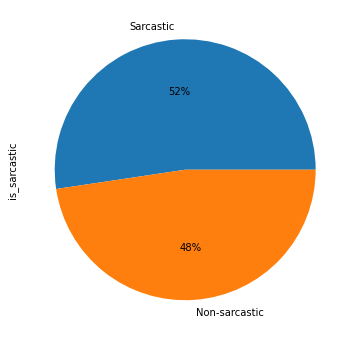

In [5]:
print('--'*30); print('Value Counts for `is_sarcastic` label'); print('--'*30)
print(f'Sarcastic count: {data[data.is_sarcastic == 1].shape[0]} i.e. {round(data[data.is_sarcastic == 1].shape[0]/data.shape[0]*100, 0)}%')
print(f'Non Sarcastic count: {data[data.is_sarcastic == 0].shape[0]} i.e. {round(data[data.is_sarcastic == 0].shape[0]/data.shape[0]*100, 0)}%')

print('--'*30); print('Distributon of `is_sarcastic` label'); print('--'*30)
_ = data['is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

In [6]:
print('Analysis of `is_sarcastic` label by news website'); print('--'*30)

hf = data[data['article_link'].str.contains('huffingtonpost.com')].shape[0]
op = data[data['article_link'].str.contains('theonion.com')].shape[0]

is_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_hf = data.loc[(data['article_link'].str.contains('huffingtonpost.com')) & (data['is_sarcastic'] == 0)].shape[0]

is_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 1)].shape[0]
not_sarcastic_op = data.loc[(data['article_link'].str.contains('theonion.com')) & (data['is_sarcastic'] == 0)].shape[0]

display(pd.DataFrame([[is_sarcastic_hf, is_sarcastic_op], [not_sarcastic_hf, not_sarcastic_op]], 
                     columns = ['huffingtonpost', 'theonion'], index = ['Sarcastic', 'Non-sarcastic']))

Analysis of `is_sarcastic` label by news website
------------------------------------------------------------


,huffingtonpost,theonion
Sarcastic,0,13634
Non-sarcastic,14985,1


In [7]:
# Checking 5 random headlines and labels from the data
print('--'*30); print('Checking 5 random headlines and labels from the data'); print('--'*30)
rands = random.sample(range(1, data.shape[0]), 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

------------------------------------------------------------
Checking 5 random headlines and labels from the data
------------------------------------------------------------
Headline: earth passed over for invasion
label: 1

Headline: white castle bathroom stall celebrates 5th conception
label: 1

Headline: trump's possible pardon of joe arpaio is destructive and unpresidential
label: 0

Headline: sweden and the wakening of eco-integrity
label: 0

Headline: ohio state uses t-shirt blaster to pass out diplomas
label: 1



------------------------------------------------------------
Checking 5 random headlines and labels from the data where the length of headline is > 100
------------------------------------------------------------
Headline: first-generation immigrant couple still adjusting to life of being featured in son's standup routines
label: 1

Headline: 'it's like you're hearing me but you're not listening to me,' says man to representative on oscar mayer customer service hotline
label: 1

Headline: ciro guerra's 'embrace of the serpent' at cannes: a conversation with the colombian director about shamanism
label: 0

Headline: grumblethor the mischievous pleased with mayhem his magical antics have wrought upon white house–fbi relations
label: 1

Headline: facebook informs data leak victims whether they need to burn down house, cut off fingerprints, start anew
label: 1

------------------------------------------------------------
Distributon of label where the length of headline is > 100
----------

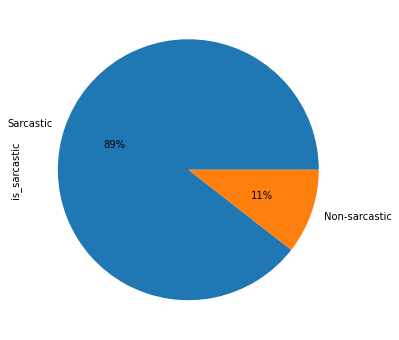

In [8]:
# Checking 5 random headlines and labels from the data where the length of headline is > 100
print('--'*30); print('Checking 5 random headlines and labels from the data where the length of headline is > 100'); print('--'*30)
indexes = list(data.loc[data['headline'].str.len() > 100, 'headline'].index)
rands = random.sample(indexes, 5)
headlines, labels = list(data.loc[rands, 'headline']), list(data.loc[rands, 'is_sarcastic'])

_ = [print(f'Headline: {head}\nlabel: {label}\n') for head, label in zip(headlines, labels)]

print('--'*30); print('Distributon of label where the length of headline is > 100'); print('--'*30)
_ = data.loc[indexes, 'is_sarcastic'].value_counts().plot(kind = 'pie', autopct = '%.0f%%', labels = ['Sarcastic', 'Non-sarcastic'], figsize = (10, 6))

### **Observations**
* 48% of the data have sarcastic labels whereas 52% don't.
* Suprising! There are no headlines from HuffPost that are sarcastic whereas all but one from The Onion are sarcastic.
* Based on some random headlines seen above, it appears that the data is mostly lower-cased. Pre-processing such as removing punctuations and lemmatization can be used.
* There are digits in the headlines for e.g. `3 things i needed to hear when i weighed 300 pounds` where removing the digits wouldn't help.
* 89% of data with length of sentence (headlines) > 100 are sarcastic headlines.

# 2. Drop one column

In [9]:
print('Dropping `article_link` column from the data'); print('--'*30)
data.drop('article_link', axis = 1, inplace = True)

Dropping `article_link` column from the data
------------------------------------------------------------


# 3. Get length of each sentence

In [10]:
lengths = data['headline'].str.len()

In [11]:
print('Headline:', data['headline'][1])
print('Length:',lengths[1])

Headline: dem rep. totally nails why congress is falling short on gender, racial equality
Length: 79


In [12]:
lengths.min()

7

In [13]:
lengths.max()

926

### Data Preprocessing
Few of the data pre-processing steps taken before applying model on the data

* Converting to lower case, avoid any capital cases
* Converting apostrophe to the standard lexicons
* Removing punctuations
* Lemmatization

In [14]:
import nltk; nltk.download('wordnet'); nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet as wn
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import string

nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\prasa\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [15]:
# Reference: https://github.com/sharmapratik88/AppliedNLPWorkshop/blob/master/HelperCodes/text_prep_config.py
appos = {"ain't": "am not", "aren't": "are not", "can't": "cannot", 
         "can't've": "cannot have", "'cause": "because", 
         "could've": "could have", "couldn't": "could not", 
         "couldn't've": "could not have", "didn't": "did not", 
         "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
         "hadn't've": "had not have", "hasn't": "has not", 
         "haven't": "have not", "he'd": "he would", "he'd've": "he would have", 
         "he'll": "he will", "he'll've": "he will have", 
         "he's": "he is", "how'd": "how did", 
         "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
         "I'd": "I would", "I'd've": "I would have", "I'll": "I will", 
         "I'll've": "I will have", "I'm": "I am", "I've": "I have", 
         "isn't": "is not", "it'd": "it would", "it'd've": "it would have", 
         "it'll": "it will", "it'll've": "it will have", "it's": "it is", 
         "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
         "might've": "might have", "mightn't": "might not", 
         "mightn't've": "might not have", "must've": "must have", 
         "mustn't": "must not", "mustn't've": "must not have", 
         "needn't": "need not", "needn't've": "need not have",
         "o'clock": "of the clock", "oughtn't": "ought not", 
         "oughtn't've": "ought not have", "shan't": "shall not", 
         "sha'n't": "shall not", "shan't've": "shall not have", 
         "she'd": "she would", "she'd've": "she would have", 
         "she'll": "she will", "she'll've": "she will have",
         "she's": "she is", "should've": "should have", 
         "shouldn't": "should not", "shouldn't've": "should not have", 
         "so've": "so have", "so's": "so is", 
         "that'd": "that had", "that'd've": "that would have", 
         "that's": "that that is", "there'd": "there would", 
         "there'd've": "there would have", "there's": "there is", 
         "they'd": "they would", "they'd've": "they would have", 
         "they'll": "they will", "they'll've": "they will have", 
         "they're": "they are", "they've": "they have", 
         "to've": "to have", "wasn't": "was not", "we'd": "we would", 
         "we'd've": "we would have", "we'll": "we will", 
         "we'll've": "we will have", "we're": "we are", 
         "we've": "we have", "weren't": "were not", 
         "what'll": "what will", "what'll've": "what will have", 
         "what're": "what are", "what's": "what is", 
         "what've": "what have", "when's": "when is", 
         "when've": "when have", "where'd": "where did", 
         "where's": "where is", "where've": "where have", 
         "who'll": "who will", "who'll've": "who will have", 
         "who's": "who is", "who've": "who have", 
         "why's": "why is", "why've": "why have", "will've": "will have", 
         "won't": "will not", "won't've": "will not have",
         "would've": "would have", "wouldn't": "would not", 
         "wouldn't've": "would not have", "y'all": "you all", 
         "y'all'd": "you all would", "y'all'd've": "you all would have", 
         "y'all're": "you all are", "y'all've": "you all have", 
         "you'd": "you would", "you'd've": "you would have",
         "you'll": "you will", "you'll've": "you will have", 
         "you're": "you are", "you've": "you have"}


In [16]:
# Helper function to replace appos
def replace_words(headline):
    cleaned_headlines = []
    for word in str(headline).split():
        if word.lower() in appos.keys():
            cleaned_headlines.append(appos[word.lower()])
        else:
            cleaned_headlines.append(word)
    return ' '.join(cleaned_headlines)

# Helper function to remove punctuations
# Reference: https://www.programiz.com/python-programming/methods/string/translate
PUNCT_TO_REMOVE = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~' #string.punctuation
def remove_punctuation(text):
    """function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

# Helper function to lemmatize
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    return ''.join([lemmatizer.lemmatize(word) for word in text])

# Helper function to remove stopwords
stoplist = set(stopwords.words('english'))
stoplist.remove('not')
def remove_stopwords(text):
    """function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in stoplist])
# Second helper function for lemmatizing
lemmatizer = WordNetLemmatizer()
def lem(text):
    pos_dict = {'N': wn.NOUN, 'V': wn.VERB, 'J': wn.ADJ, 'R': wn.ADV}
    return(' '.join([lemmatizer.lemmatize(w,pos_dict.get(t, wn.NOUN)) for w,t in nltk.pos_tag(text.split())]))
# Helper function for wordcloud
# Reference: https://www.kaggle.com/aashita/word-clouds-of-various-shapes
def plot_wordcloud(text, mask = None, max_words = 500, max_font_size = 40, 
                   figure_size = (12, 6), title = None, title_size = 15):
    wordcloud = WordCloud(background_color = 'white', max_words = max_words,
                          random_state = 42, width = 350, height = 150, 
                          mask = mask, stopwords = stoplist, collocations = False)
    wordcloud.generate(str(text))
    
    plt.figure(figsize = figure_size)
    plt.imshow(wordcloud, interpolation = 'bilinear');
    plt.title(title, fontdict = {'size': title_size, 'color': 'black', 
                               'verticalalignment': 'bottom'})
    plt.axis('off');
    plt.tight_layout()

In [17]:
print('--'*30); print('Converting headlines to lower case')
data['cleaned_headline'] = data['headline'].apply(lambda x : x.lower())

print('Replacing apostrophes to the standard lexicons')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x : replace_words(x))

print('Removing punctuations')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_punctuation(x))

print('Applying Lemmatizer')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: lem(x))

print('Removing multiple spaces between words')
data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: re.sub(' +', ' ', x))

# print('Removing stopwords')
# data['cleaned_headline'] = data['cleaned_headline'].apply(lambda x: remove_stopwords(x))
print('--'*30)

------------------------------------------------------------
Converting headlines to lower case
Replacing apostrophes to the standard lexicons
Removing punctuations
Applying Lemmatizer
Removing multiple spaces between words
------------------------------------------------------------


As different lines are of different length. We need to pad the our sequences using the max length.

In [18]:
# Get length of each line
data['line_length'] = data['cleaned_headline'].str.len()
print('--'*40); print('Get the length of each line, find the lines ranges'); 
print('Length of line ranges from', data['line_length'].min(), 'to', data['line_length'].max()); print('--'*40)

print('Minimum line length: {}'.format(data['line_length'].min()))
print('Maximum line length: {}'.format(data['line_length'].max()))
print('Line with maximum length:\n{}'.format(data[data['line_length'] == data['line_length'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the length of each line, find the lines ranges
Length of line ranges from 7 to 893
--------------------------------------------------------------------------------
Minimum line length: 7
Maximum line length: 893
Line with maximum length:
hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book until handle catch hook attached to lever

In [19]:
print('--'*40); print('Get the number of words, find the maximum number of words and print the maximum number of words'); 
# Get length of each line
data['nb_words'] = data['cleaned_headline'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(data['nb_words'].min()))
print('Maximum number of words: {}'.format(data['nb_words'].max()))
print('Line with maximum number of words: \n{}'.format(data[data['nb_words'] == data['nb_words'].max()]['cleaned_headline'].values[0]))

--------------------------------------------------------------------------------
Get the number of words, find the maximum number of words and print the maximum number of words
Minimum number of words: 2
Maximum number of words: 151
Line with maximum number of words: 
hot wheel ranked number one toy for rolling down ramp knocking over domino that send marble down a funnel dropping onto teetertotter that yank on string causing pulley system to raise wooden block propelling series of twine roller that unwind spring launching tennis ball across room inching tire down slope until it hit power switch activating table fan that blow toy ship with nail attached to it across kiddie pool popping water balloon that fill cup weighing down lever that force basketball down track nudging broomstick on axis to rotate allowing golf ball to roll into sideways coffee mug which tumble down row of hardcover book until handle catch hook attached to lever that cause wooden mallet to slam down on serving spoo

Word Cloud of Sarcastic and Non-sarcastic Headlines


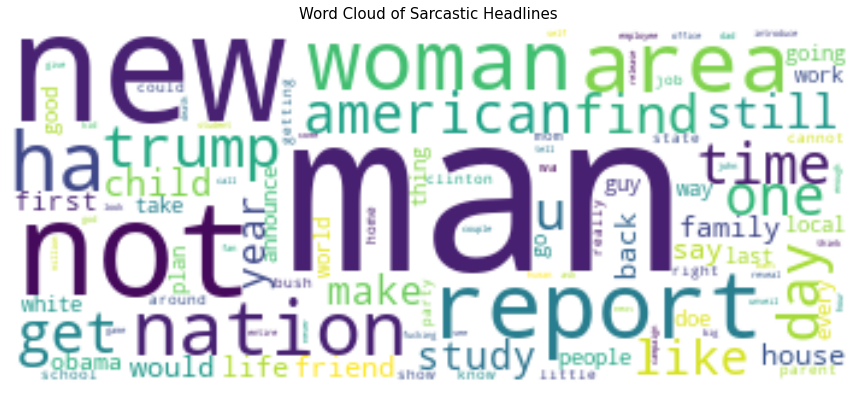

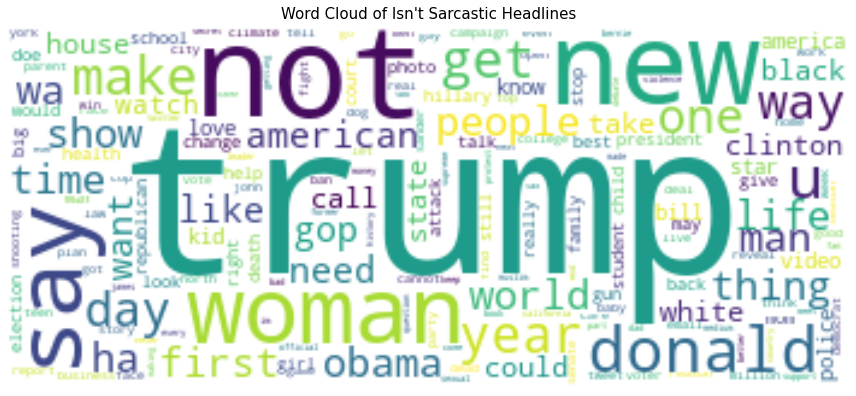

In [20]:
print('Word Cloud of Sarcastic and Non-sarcastic Headlines')
data['headline'] = data['headline'].fillna('')
sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 1, 'cleaned_headline'])
plot_wordcloud(sarcastic_headlines, title = 'Word Cloud of Sarcastic Headlines')

non_sarcastic_headlines = ' '.join(data.loc[data['is_sarcastic'] == 0, 'cleaned_headline'])
plot_wordcloud(non_sarcastic_headlines, title = 'Word Cloud of Isn\'t Sarcastic Headlines')


# 4. Define parameters

In [21]:
max_features = 10000
maxlen = data['nb_words'].max()
embedding_size = 200

# 5. Get indices for words

In [22]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(data['cleaned_headline']))

# 6. Create features and labels

In [23]:
X = tokenizer.texts_to_sequences(data['cleaned_headline'])
X = pad_sequences(X, maxlen = maxlen)
y = np.asarray(data['is_sarcastic'])

print(f'Number of Samples: {len(X)}')
print(f'Number of Labels: {len(y)}')
print(f'\nFirst headline:\n{X[0]}\n\nLabel of the first headline: {y[0]}')

Number of Samples: 28619
Number of Labels: 28619

First headline:
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  326 2958 5781 2067    2  692 1093]

Label of the first headline: 1


# 7. Get vocab size

In [24]:
# Reserve padding (indexed zero)
w2i = tokenizer.word_index
vocab_size = len(w2i) + 1
print(f'Number of unique tokens: {vocab_size}')

Number of unique tokens: 26042


# 8. Create a weight matrix using GloVe embeddings

In [25]:
#glove_file = '../Data/glove.6B.zip'
#Extract Glove embedding zip file
#from zipfile import ZipFile
#with ZipFile(glove_file, 'r') as z:
#  z.extractall()

In [26]:
glove_file = project_path + 'glove.6B'
f = open(os.path.join(glove_file , 'glove.6B.200d.txt'), encoding="utf8")
embeddings = {}
for o in f:
    word = o.split(' ')[0]
    embd = o.split(' ')[1:]
    embd = np.asarray(embd, dtype = 'float32')
    embeddings[word] = embd

In [27]:
# Getting the minimum number of words
num_words = min(max_features, vocab_size) + 1

embedding_matrix = np.zeros((num_words, embedding_size))
for word, i in tokenizer.word_index.items():
    if i > max_features: continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

len(embeddings.values())

400000

# 9. Define and compile a Bidirectional LSTM model

Create and Compile Model

    Split the data into train, valid and test set so that it's easy to compare and evaluate
    Use Sequential model instance
    Add Embedding layer
    Bidirectional(LSTM) layer
    GlobalMaxPool1D layer
    Dense, dropout layers
    Add a final dense layer with sigmoid activation for binary classification



In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = random_state, shuffle = True)

print('---'*20, f'\nNumber of rows in training dataset: {x_train.shape[0]}')
print(f'Number of columns in training dataset: {x_train.shape[1]}')
print(f'Number of unique words in training dataset: {len(np.unique(np.hstack(x_train)))}')

print('---'*20, f'\nNumber of rows in test dataset: {x_test.shape[0]}')
print(f'Number of columns in test dataset: {x_test.shape[1]}')
print(f'Number of unique words in test dataset: {len(np.unique(np.hstack(x_test)))}')

------------------------------------------------------------ 
Number of rows in training dataset: 22895
Number of columns in training dataset: 151
Number of unique words in training dataset: 9975
------------------------------------------------------------ 
Number of rows in test dataset: 5724
Number of columns in test dataset: 151
Number of unique words in test dataset: 7640


In [29]:
model = Sequential()
model.add(Embedding(num_words, embedding_size, embeddings_initializer = Constant(embedding_matrix), input_length = maxlen, trainable = False))
model.add(Bidirectional(LSTM(128, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dropout(0.5, input_shape = (256,)))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (128,)))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5, input_shape = (64,)))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

# Adding callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 10)  
mc = ModelCheckpoint('sarcasm_detector.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)
lr_r = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 5)
logdir = 'log'; tb = TensorBoard(logdir, histogram_freq = 1)
callbacks = [es, mc, lr_r, tb]

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 151, 200)          2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 151, 256)          336896    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [30]:
#from keras.utils import plot_model
#tf.keras.utils.plot_model(model, show_shapes = True)

# 10. Fit the model and check the validation accuracy

In [31]:
batch_size = 100
epochs = 6

h = model.fit(x_train, y_train, epochs = epochs, validation_split = 0.2, batch_size = batch_size, verbose = 2, callbacks = callbacks)

Train on 18316 samples, validate on 4579 samples
Epoch 1/6

Epoch 00001: val_loss improved from inf to 0.44468, saving model to sarcasm_detector.h5
18316/18316 - 215s - loss: 0.5966 - accuracy: 0.6653 - val_loss: 0.4447 - val_accuracy: 0.7934
Epoch 2/6

Epoch 00002: val_loss improved from 0.44468 to 0.39897, saving model to sarcasm_detector.h5
18316/18316 - 221s - loss: 0.4399 - accuracy: 0.8009 - val_loss: 0.3990 - val_accuracy: 0.8251
Epoch 3/6

Epoch 00003: val_loss improved from 0.39897 to 0.36024, saving model to sarcasm_detector.h5
18316/18316 - 221s - loss: 0.3830 - accuracy: 0.8336 - val_loss: 0.3602 - val_accuracy: 0.8421
Epoch 4/6

Epoch 00004: val_loss did not improve from 0.36024
18316/18316 - 213s - loss: 0.3384 - accuracy: 0.8564 - val_loss: 0.3646 - val_accuracy: 0.8356
Epoch 5/6

Epoch 00005: val_loss improved from 0.36024 to 0.33385, saving model to sarcasm_detector.h5
18316/18316 - 216s - loss: 0.3070 - accuracy: 0.8720 - val_loss: 0.3339 - val_accuracy: 0.8508
Epoch 

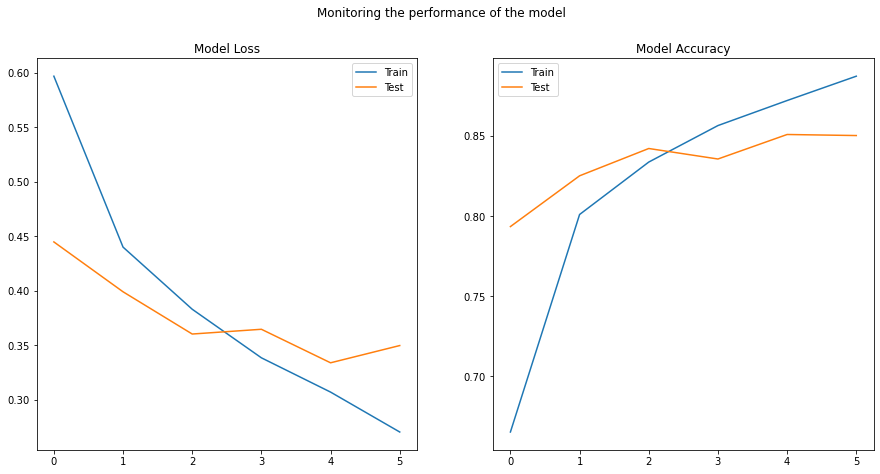

In [32]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 7.2))
f.suptitle('Monitoring the performance of the model')

ax1.plot(h.history['loss'], label = 'Train')
ax1.plot(h.history['val_loss'], label = 'Test')
ax1.set_title('Model Loss')
ax1.legend(['Train', 'Test'])

ax2.plot(h.history['accuracy'], label = 'Train')
ax2.plot(h.history['val_accuracy'], label = 'Test')
ax2.set_title('Model Accuracy')
ax2.legend(['Train', 'Test'])

plt.show()

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test, verbose = 0)
print('Overall Accuracy: {}'.format(round(accuracy * 100, 0)))

Overall Accuracy: 86.0


In [34]:
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(f'Classification Report:\n{classification_report(y_pred, y_test)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.85      0.87      3076
           1       0.84      0.86      0.85      2648

    accuracy                           0.86      5724
   macro avg       0.86      0.86      0.86      5724
weighted avg       0.86      0.86      0.86      5724



------------------------------------------------------------
Confusion Matrix


,Non-sarcastic,Sarcastic
Non-sarcastic,2629,366
Sarcastic,447,2282


------------------------------------------------------------


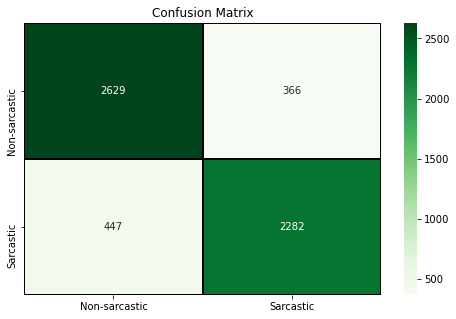

In [35]:
print('--'*30); print('Confusion Matrix')
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm , index = ['Non-sarcastic', 'Sarcastic'] , columns = ['Non-sarcastic','Sarcastic'])
display(cm); print('--'*30)

plt.figure(figsize = (8, 5))
_ = sns.heatmap(cm, cmap= 'Greens', linecolor = 'black' , linewidth = 1 , annot = True, 
            fmt = '' , xticklabels = ['Non-sarcastic', 'Sarcastic'], 
            yticklabels = ['Non-sarcastic', 'Sarcastic']).set_title('Confusion Matrix')

### Conclusion

* Model achieved 86% accuracy on the test set; classification report and confusion matrix were also printed.
